# D·ª± b√°o ƒëi·ªán nƒÉng ti√™u th·ª• c·ªßa kh√°ch h√†ng


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import os
import joblib
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import Adam
import pyodbc
import datetime

## T·∫£i d·ªØ li·ªáu

In [8]:

# K·∫øt n·ªëi SQL Server
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=LAPTOP-K2A0A359\\SERVERCHAU;DATABASE=DWDienLuc;Trusted_Connection=yes;')

# C√¢u truy v·∫•n SQL v·ªõi PIVOT v√† ƒëi·ªÅu ki·ªán l·ªçc nh√≥m kh√°ch h√†ng
query = """
SELECT *
FROM (
    SELECT 
        kh.MA_KHANG,
        FORMAT(hd.NGAY_PHANH, 'yyyy-MM') AS Thang,
        SUM(ft.DIEN_TTHU) AS DIEN_TTHU
    FROM Fact_TieuThu ft
    JOIN Dim_KhachHang kh ON ft.DimKhachHangId = kh.MA_KHANG
    JOIN Dim_HoaDon hd ON ft.Dim_HoaDonID = hd.ID_HDON
    WHERE hd.NGAY_PHANH >= '2022-01-01' 
      AND hd.NGAY_PHANH <= '2023-12-31'
      AND kh.NHOM_KHANG = N'Kh√°ch h√†ng b√¨nh th∆∞·ªùng'
    GROUP BY kh.MA_KHANG, FORMAT(hd.NGAY_PHANH, 'yyyy-MM')
) AS src
PIVOT (
    SUM(DIEN_TTHU)
    FOR Thang IN (
        [2022-01], [2022-02], [2022-03], [2022-04], [2022-05], [2022-06],
        [2022-07], [2022-08], [2022-09], [2022-10], [2022-11], [2022-12],
        [2023-01], [2023-02], [2023-03], [2023-04], [2023-05], [2023-06],
        [2023-07], [2023-08], [2023-09], [2023-10], [2023-11], [2023-12]
    )
) AS pivot_table
"""

# Th·ª±c hi·ªán truy v·∫•n v√† ƒë·ªçc k·∫øt qu·∫£ v√†o DataFrame
df = pd.read_sql(query, conn)
conn.close()

df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10400\1321474743.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


MA_KHANG  2022-01  2022-02  2022-03  2022-04  2022-05  2022-06  \
0  PP05000940386     97.0    104.0     76.0     98.0     98.0    111.0   
1  PP05000941917    143.0     91.0    111.0     67.0     64.0    222.0   
2  PP09000900971    428.0    305.0    480.0    446.0    427.0    447.0   
3  PP05000999895    329.0    314.0    388.0    478.0    557.0    747.0   
4  PP05000966548    174.0    165.0    148.0    182.0    184.0    282.0   

   2022-07  2022-08  2022-09  ...  2023-03  2023-04  2023-05  2023-06  \
0     99.0    103.0     93.0  ...     63.0     75.0     87.0    104.0   
1    227.0      NaN     13.0  ...    119.0    176.0    241.0    337.0   
2    330.0    387.0    314.0  ...    186.0    226.0    288.0    353.0   
3    821.0    725.0    766.0  ...    309.0    234.0    215.0    234.0   
4    320.0    294.0    308.0  ...    168.0    250.0    263.0    340.0   

   2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  
0     91.0     99.0     99.0      NaN    116.0     70.0  
1    337.0    146.0     32.0     38.0      NaN     89.0  
2     69.0      1.0     37.0      NaN      NaN    189.0  
3    247.0    215.0    267.0      NaN    553.0    129.0  
4    357.0    392.0    433.0    338.0      NaN    422.0  

[5 rows x 25 columns]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287746 entries, 0 to 287745
Data columns (total 25 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   MA_KHANG  287746 non-null  object 
 1   2022-01   259132 non-null  float64
 2   2022-02   275826 non-null  float64
 3   2022-03   256231 non-null  float64
 4   2022-04   247566 non-null  float64
 5   2022-05   228023 non-null  float64
 6   2022-06   281335 non-null  float64
 7   2022-07   278373 non-null  float64
 8   2022-08   249221 non-null  float64
 9   2022-09   284051 non-null  float64
 10  2022-10   283615 non-null  float64
 11  2022-11   253136 non-null  float64
 12  2022-12   285006 non-null  float64
 13  2023-01   269805 non-null  float64
 14  2023-02   284514 non-null  float64
 15  2023-03   281806 non-null  float64
 16  2023-04   283568 non-null  float64
 17  2023-05   284562 non-null  float64
 18  2023-06   284556 non-null  float64
 19  2023-07   284330 non-null  float64
 20  2023

## X·ª≠ l√Ω d·ªØ li·ªáu

### Ki·ªÉm tra d·ªØ li·ªáu thi·∫øu

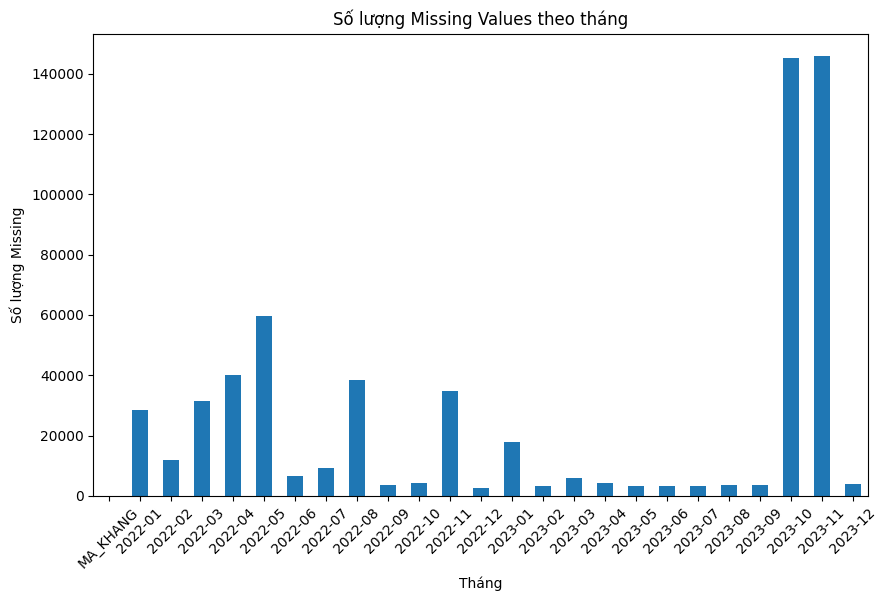

S·ªë l∆∞·ª£ng kh√°ch h√†ng b·ªã lo·∫°i b·ªè do c√≥ > 40% missing values: 3261


In [9]:
# Ki·ªÉm tra missing values theo c·ªôt (th√°ng)
missing_values = df.isna().sum()
plt.figure(figsize=(10,6))
missing_values.plot(kind='bar')
plt.title('S·ªë l∆∞·ª£ng Missing Values theo th√°ng')
plt.xlabel('Th√°ng')
plt.ylabel('S·ªë l∆∞·ª£ng Missing')
plt.xticks(rotation=45)
plt.show()

# Lo·∫°i b·ªè kh√°ch h√†ng c√≥ h∆°n 40% d·ªØ li·ªáu b·ªã thi·∫øu
missing_percent = df.isna().mean(axis=1)
df_filtered = df[missing_percent <= 0.4]

# Th·ªëng k√™ s·ªë l∆∞·ª£ng kh√°ch h√†ng b·ªã lo·∫°i b·ªè
total_before = df.shape[0]
total_after = df_filtered.shape[0]
num_dropped = total_before - total_after
print(f"S·ªë l∆∞·ª£ng kh√°ch h√†ng b·ªã lo·∫°i b·ªè do c√≥ > 40% missing values: {num_dropped}")

### X·ª≠ l√Ω d·ªØ li·ªáu thi·∫øu: ch·ªâ n·ªôi suy n·∫øu ph√≠a tr∆∞·ªõc ƒë√£ c√≥ gi√° tr·ªã th·ª±c

In [10]:
min_valid_months = 12
# H√†m forward fill ch·ªâ khi c√≥ gi√° tr·ªã tr∆∞·ªõc ƒë√≥
def forward_fill_only_if_prev(row):
    row_interp = row.copy()
    for i in range(len(row_interp)):
        if pd.isna(row_interp.iloc[i]):
            prev_vals = row_interp.iloc[:i]
            if prev_vals.notna().any():
                last_valid = prev_vals[prev_vals.notna()].iloc[-1]
                row_interp.iloc[i] = last_valid
    return row_interp
# L·∫•y danh s√°ch c√°c c·ªôt tr·ª´ 'MA_KHANG' ƒë·ªÉ x·ª≠ l√Ω chu·ªói th·ªùi gia
cols = [c for c in df_filtered.columns if c != 'MA_KHANG']
processed_rows = []
for idx, row in df_filtered[cols].iterrows():
    processed = forward_fill_only_if_prev(row.copy())
    if processed.notna().sum() >= min_valid_months:
        processed_rows.append(processed)

df_time_ready = pd.DataFrame(processed_rows, columns=cols)

# Chuy·ªÉn ƒë·ªïi l·∫°i th√†nh DataFrame v·ªõi MA_KHANG
if 'MA_KHANG' in df_filtered.columns:
    df_time_ready['MA_KHANG'] = df_filtered.loc[df_time_ready.index, 'MA_KHANG'].values
print(f'S·ªë kh√°ch h√†ng c√≤n l·∫°i sau x·ª≠ l√Ω: {df_time_ready.shape[0]}')

S·ªë kh√°ch h√†ng c√≤n l·∫°i sau x·ª≠ l√Ω: 284485


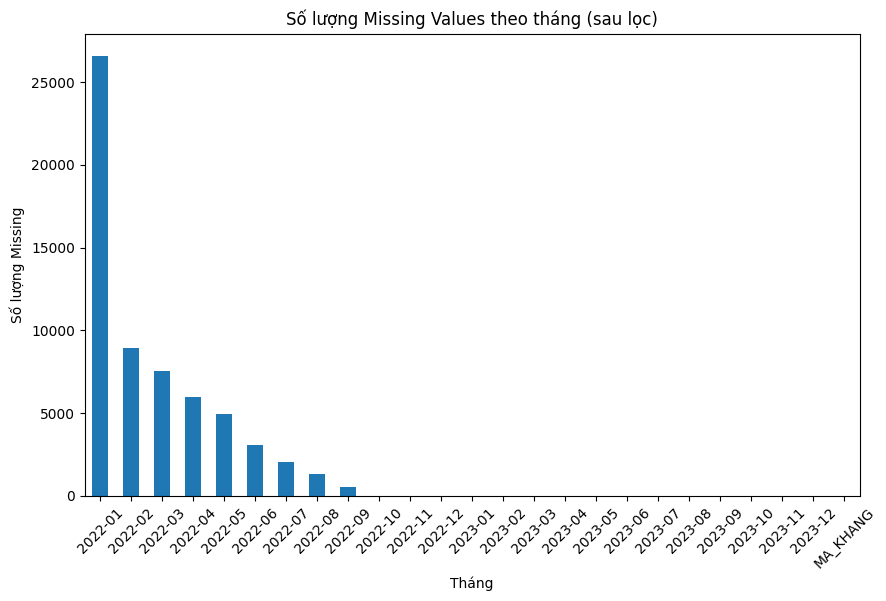

In [20]:
# Ki·ªÉm tra missing values sau khi l·ªçc
missing_values = df_time_ready.isna().sum()
plt.figure(figsize=(10,6))
missing_values.plot(kind='bar')
plt.title('S·ªë l∆∞·ª£ng Missing Values theo th√°ng (sau l·ªçc)')
plt.xlabel('Th√°ng')
plt.ylabel('S·ªë l∆∞·ª£ng Missing')
plt.xticks(rotation=45)
plt.show()

### X·ª≠ l√Ω outlier b·∫±ng IQR

ƒê√£ lo·∫°i 17092 kh√°ch h√†ng (6.01%) ‚Äî c√≤n l·∫°i 267393/284485


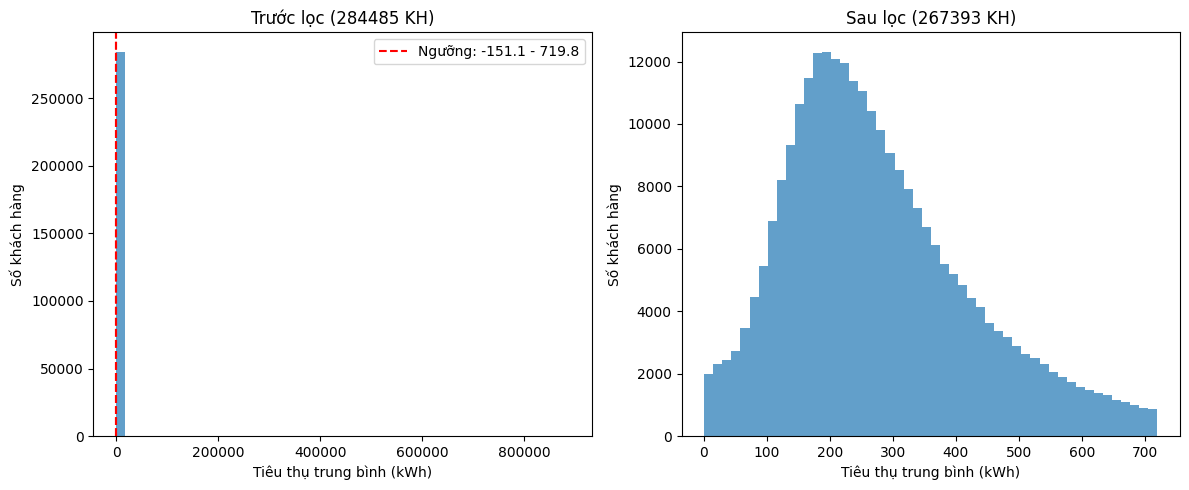

In [11]:
# X·ª≠ l√Ω outlier d·ª±a tr√™n gi√° tr·ªã ti√™u th·ª• trung b√¨nh c·ªßa kh√°ch h√†ng
has_id = 'MA_KHANG' in df_time_ready.columns
means = df_time_ready.drop(columns='MA_KHANG') if has_id else df_time_ready
customer_means = means.mean(axis=1)

# X√°c ƒë·ªãnh ng∆∞·ª°ng outlier
Q1, Q3 = customer_means.quantile([0.25, 0.75])
IQR = Q3 - Q1
low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = (customer_means < low) | (customer_means > high)

# Lo·∫°i b·ªè outlier
before, after = len(df_time_ready), (~outliers).sum()
df_time_ready = df_time_ready.loc[~outliers].copy()

print(f"ƒê√£ lo·∫°i {before - after} kh√°ch h√†ng ({(before - after)/before:.2%}) ‚Äî c√≤n l·∫°i {after}/{before}")

# Tr·ª±c quan h√≥a ph√¢n ph·ªëi tr∆∞·ªõc v√† sau
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(customer_means, bins=50, alpha=0.7)
axes[0].axvline(low, color='red', linestyle='--', label=f'Ng∆∞·ª°ng: {low:.1f} - {high:.1f}')
axes[0].axvline(high, color='red', linestyle='--')
axes[0].set_title(f'Tr∆∞·ªõc l·ªçc ({before} KH)'); axes[0].legend()

axes[1].hist(df_time_ready.drop(columns='MA_KHANG').mean(axis=1) if has_id else df_time_ready.mean(axis=1), bins=50, alpha=0.7)
axes[1].set_title(f'Sau l·ªçc ({after} KH)')

for ax in axes: ax.set_xlabel('Ti√™u th·ª• trung b√¨nh (kWh)'); ax.set_ylabel('S·ªë kh√°ch h√†ng')
plt.tight_layout(); plt.show()


### Ph√¢n t√≠ch chu·ªói th·ªùi gian v√† ki·ªÉm tra t√≠nh d·ª´ng

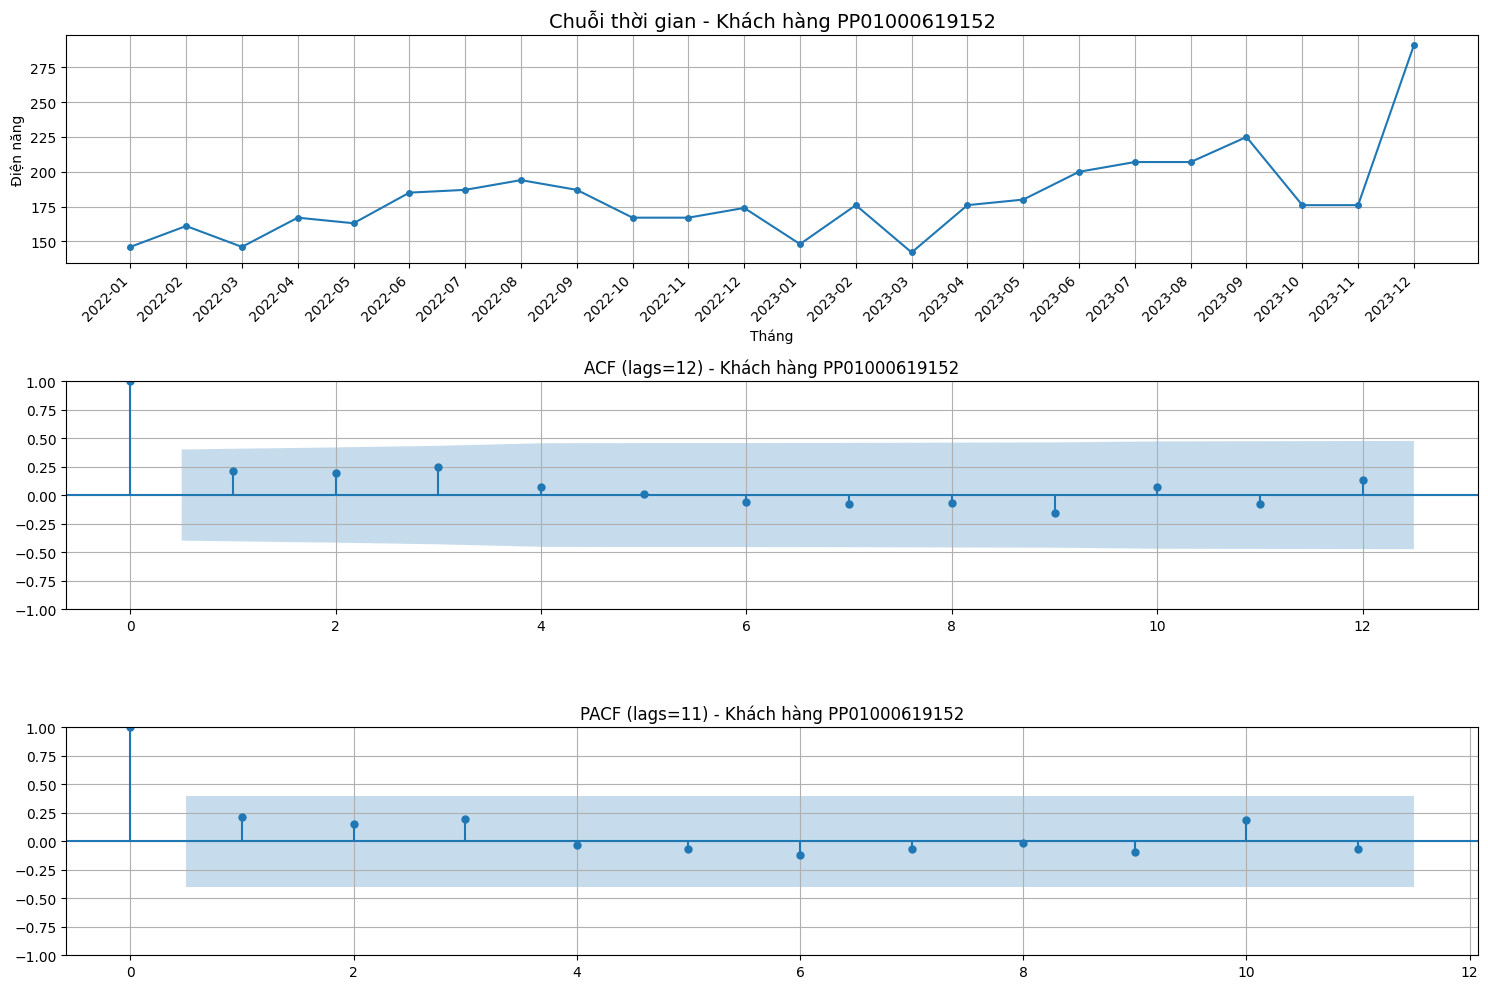

[ADF Test] Kh√°ch h√†ng PP01000619152
ADF Statistic: 0.282921
p-value: 0.976547
Critical Values:
  1%: -4.012034
  5%: -3.104184
  10%: -2.690987
K·∫øt lu·∫≠n: Kh√¥ng ·ªïn ƒë·ªãnh (95%)



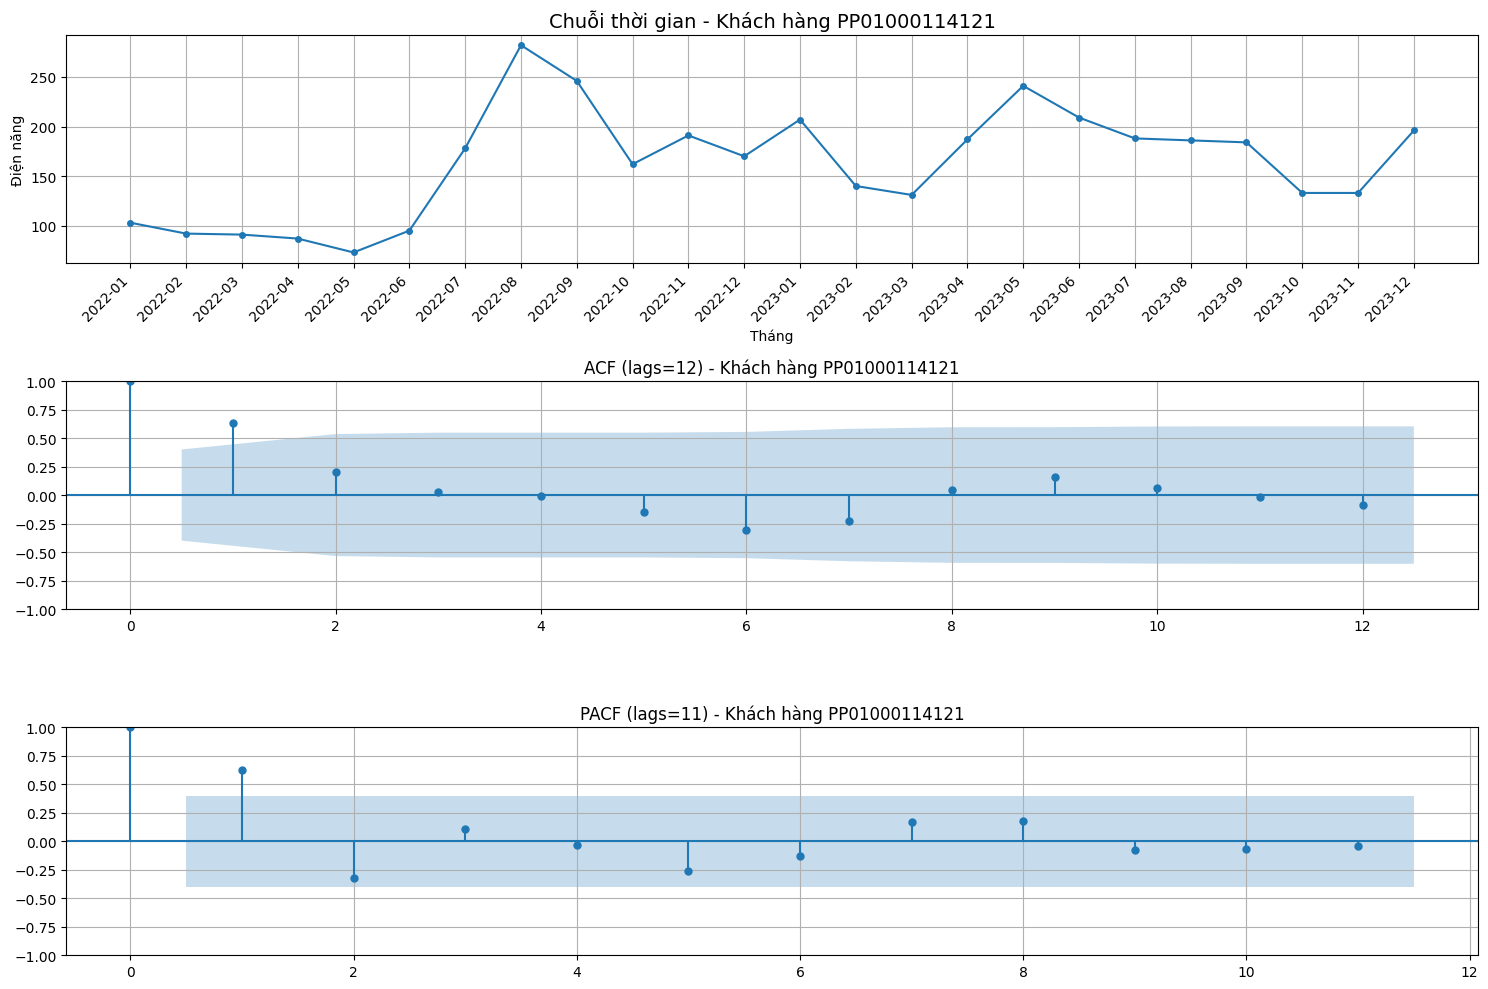

[ADF Test] Kh√°ch h√†ng PP01000114121
ADF Statistic: -4.385409
p-value: 0.000315
Critical Values:
  1%: -3.889266
  5%: -3.054358
  10%: -2.666984
K·∫øt lu·∫≠n: ·ªîn ƒë·ªãnh (95%)



In [8]:
def analyze_time_series_customer(data, customer_idx=0, lags=12):
    row = data.iloc[customer_idx]
    customer_id = row.get('MA_KHANG', f"#{customer_idx}")
    series = row.drop('MA_KHANG') if 'MA_KHANG' in row else row
    series = pd.Series(series.to_numpy(), index=series.index.astype(str)).dropna()

    lags_acf = min(lags, len(series) - 1)
    lags_pacf = min(lags, max(1, (len(series) // 2) - 1))

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    axes[0].plot(series, marker='o', linestyle='-', markersize=4)
    axes[0].set_title(f'Chu·ªói th·ªùi gian - Kh√°ch h√†ng {customer_id}', fontsize=14)
    axes[0].set_xlabel('Th√°ng')
    axes[0].set_ylabel('ƒêi·ªán nƒÉng')
    axes[0].grid(True)
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

    plot_acf(series, lags=lags_acf, ax=axes[1])
    axes[1].set_title(f'ACF (lags={lags_acf}) - Kh√°ch h√†ng {customer_id}')
    axes[1].grid(True)

    plot_pacf(series, lags=lags_pacf, ax=axes[2])
    axes[2].set_title(f'PACF (lags={lags_pacf}) - Kh√°ch h√†ng {customer_id}')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    adf_stat, p_value, _, _, crit_vals, _ = adfuller(series)
    print(f"[ADF Test] Kh√°ch h√†ng {customer_id}")
    print(f"ADF Statistic: {adf_stat:.6f}")
    print(f"p-value: {p_value:.6f}")
    print("Critical Values:")
    for k, v in crit_vals.items():
        print(f"  {k}: {v:.6f}")
    print("K·∫øt lu·∫≠n:", "·ªîn ƒë·ªãnh" if p_value < 0.05 else "Kh√¥ng ·ªïn ƒë·ªãnh", "(95%)\n")

    return series


# Ph√¢n t√≠ch 2 kh√°ch h√†ng ƒë·∫ßu
for i in range(min(2, len(df_time_ready))):
    analyze_time_series_customer(df_time_ready, customer_idx=i, lags=12)


### Chu·∫©n b·ªã d·ªØ li·ªáu cho LSTM

In [9]:
def prepare_time_series_data(df, window_size=12, test_size=0.2, scale=True):
    if 'MA_KHANG' in df.columns:
        data = df.drop(columns=['MA_KHANG'])
    else:
        data = df.copy()
    # Ki·ªÉm tra v√† x·ª≠ l√Ω NaN trong d·ªØ li·ªáu
    if data.isna().any().any():
        print("C·∫£nh b√°o: D·ªØ li·ªáu v·∫´n c√≤n ch·ª©a gi√° tr·ªã NaN. Th·ª±c hi·ªán ƒëi·ªÅn khuy·∫øt b·ªï sung.")
        data = data.fillna(method='ffill').fillna(method='bfill').fillna(0)
    # Chu·∫©n h√≥a d·ªØ li·ªáu v·ªÅ ƒëo·∫°n [0, 1] b·∫±ng MinMaxScaler
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = data.values
        scaler = None
    # Ki·ªÉm tra v√† x·ª≠ l√Ω gi√° tr·ªã v√¥ c√πng
    if np.isinf(data_scaled).any():
        print("C·∫£nh b√°o: Ph√°t hi·ªán gi√° tr·ªã v√¥ c√πng. Thay th·∫ø b·∫±ng gi√° tr·ªã h·ªØu h·∫°n.")
        data_scaled = np.nan_to_num(data_scaled, posinf=1e6, neginf=-1e6)
    # Kh·ªüi t·∫°o danh s√°ch ƒë·ªÉ ch·ª©a c√°c c·ª≠a s·ªï d·ªØ li·ªáu (X) v√† gi√° tr·ªã m·ª•c ti√™u (y)
    X, y = [], []
    n_samples, n_features = data_scaled.shape
    # T·∫°o c√°c c·ª≠a s·ªï d·ªØ li·ªáu c√≥ k√≠ch th∆∞·ªõc window_size cho t·ª´ng kh√°ch h√†ng
    for i in range(n_samples):
        customer_data = data_scaled[i, :]
        for j in range(len(customer_data) - window_size):
            X.append(customer_data[j:j+window_size])
            y.append(customer_data[j+window_size])
    # Chuy·ªÉn ƒë·ªïi danh s√°ch th√†nh m·∫£ng NumPy         
    X = np.array(X)
    y = np.array(y)
    # Ki·ªÉm tra l·∫ßn cu·ªëi tr∆∞·ªõc khi ph√¢n chia t·∫≠p d·ªØ li·ªáu
    if np.isnan(X).any() or np.isinf(X).any() or np.isnan(y).any() or np.isinf(y).any():
        print("C·∫£nh b√°o: D·ªØ li·ªáu v·∫´n ch·ª©a NaN/Inf. X·ª≠ l√Ω l·∫ßn cu·ªëi.")
        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

    # Chia d·ªØ li·ªáu th√†nh t·∫≠p hu·∫•n luy·ªán v√† t·∫≠p ki·ªÉm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    print(f"K√≠ch th∆∞·ªõc d·ªØ li·ªáu:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")
    return X_train, X_test, y_train, y_test, scaler

window_size = 12
X_train, X_test, y_train, y_test, scaler = prepare_time_series_data(df_time_ready, window_size=window_size)

C·∫£nh b√°o: D·ªØ li·ªáu v·∫´n c√≤n ch·ª©a gi√° tr·ªã NaN. Th·ª±c hi·ªán ƒëi·ªÅn khuy·∫øt b·ªï sung.


C:\Users\Admin\AppData\Local\Temp\ipykernel_1072\1310461474.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill').fillna(0)


K√≠ch th∆∞·ªõc d·ªØ li·ªáu:
X_train: (2518300, 12, 1)
y_train: (2518300,)
X_test: (629576, 12, 1)
y_test: (629576,)


## X√¢y d·ª±ng v√† hu·∫•n luy·ªán m√¥ h√¨nh LSTM

### X√¢y d·ª±ng m√¥ h√¨nh d·ª± b√°o LSTM

In [ ]:
# H√†m x√¢y d·ª±ng m√¥ h√¨nh LSTM
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2, use_bidirectional=True, use_batchnorm=True):
    model = Sequential()
    if use_bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'), input_shape=input_shape))
    else:
        model.add(LSTM(lstm_units, return_sequences=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', input_shape=input_shape))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    if use_bidirectional:
        model.add(Bidirectional(LSTM(lstm_units // 2, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal')))
    else:
        model.add(LSTM(lstm_units // 2, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    # S·ª≠ d·ª•ng learning rate nh·ªè v√† th√™m gradient clipping
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Ki·ªÉm tra d·ªØ li·ªáu tr∆∞·ªõc khi hu·∫•n luy·ªán
print("Ki·ªÉm tra NaN trong t·∫≠p hu·∫•n luy·ªán:", np.isnan(X_train).any())
print("Ki·ªÉm tra Infinity trong t·∫≠p hu·∫•n luy·ªán:", np.isinf(X_train).any())

# X√°c ƒë·ªãnh input_shape cho m√¥ h√¨nh t·ª´ k√≠ch th∆∞·ªõc d·ªØ li·ªáu hu·∫•n luy·ªán (s·ªë b∆∞·ªõc th·ªùi gian, s·ªë ƒë·∫∑c tr∆∞ng)
input_shape = (X_train.shape[1], X_train.shape[2])
# X√¢y d·ª±ng m√¥ h√¨nh v·ªõi 64 ƒë∆°n v·ªã LSTM, dropout 0.3, s·ª≠ d·ª•ng LSTM hai chi·ªÅu
model = build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3, use_bidirectional=True)
model.summary()

Ki·ªÉm tra NaN trong t·∫≠p hu·∫•n luy·ªán: False
Ki·ªÉm tra Infinity trong t·∫≠p hu·∫•n luy·ªán: False


d:\cu·ªëi\Python\myenv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ bidirectional (Bidirectional)   ‚îÇ (None, 12, 128)        ‚îÇ        33,792 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 12, 128)        ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 12, 128)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_1 (Bidirectional) ‚îÇ (None, 64)             ‚îÇ        41,216 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 64)             ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 75,841 (296.25 KB)

 Trainable params: 75,457 (294.75 KB)

 Non-trainable params: 384 (1.50 KB)

### Hu·∫•n luy·ªán m√¥ h√¨nh LSTM v√† theo d√µi qu√° tr√¨nh h·ªçc

‚úÖ D·ªØ li·ªáu kh√¥ng ch·ª©a NaN ho·∫∑c gi√° tr·ªã v√¥ c√πng.
Epoch 1/10
31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step - loss: 0.0227 - mae: 0.0494
Epoch 1: val_loss improved from inf to 0.00050, saving model to models/lstm_best_model3.h5


31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 732s 23ms/step - loss: 0.0227 - mae: 0.0494 - val_loss: 4.9858e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 2/10
31477/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 20ms/step - loss: 5.7886e-04 - mae: 0.0156
Epoch 2: val_loss improved from 0.00050 to 0.00050, saving model to models/lstm_best_model3.h5


31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 689s 22ms/step - loss: 5.7886e-04 - mae: 0.0156 - val_loss: 4.9812e-04 - val_mae: 0.0143 - learning_rate: 0.0010
Epoch 3/10
31477/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 5.4136e-04 - mae: 0.0150
Epoch 3: val_loss improved from 0.00050 to 0.00044, saving model to models/lstm_best_model3.h5


31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 619s 20ms/step - loss: 5.4136e-04 - mae: 0.0150 - val_loss: 4.4147e-04 - val_mae: 0.0121 - learning_rate: 0.0010
Epoch 4/10
31478/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 5.3558e-04 - mae: 0.0148
Epoch 4: val_loss improved from 0.00044 to 0.00044, saving model to models/lstm_best_model3.h5


31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 606s 19ms/step - loss: 5.3558e-04 - mae: 0.0148 - val_loss: 4.3578e-04 - val_mae: 0.0120 - learning_rate: 0.0010
Epoch 5/10
31478/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 5.3545e-04 - mae: 0.0147
Epoch 5: val_loss did not improve from 0.00044
31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 613s 19ms/step - loss: 5.3545e-04 - mae: 0.0147 - val_loss: 4.4546e-04 - val_mae: 0.0124 - learning_rate: 0.0010
Epoch 6/10
31478/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 5.2086e-04 - mae: 0.0146
Epoch 6: val_loss did not improve from 0.00044

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 609s 19ms/step - loss: 5.2086e-04 - mae: 0.0146 - val_loss: 5.3614e-04 - val_mae: 0.0164 - learning_rate: 0.0010
Epoch 7/10

31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 621s 20ms/step - loss: 4.9684e-04 - mae: 0.0141 - val_loss: 4.1765e-04 - val_mae: 0.0119 - learning_rate: 2.0000e-04
Epoch 8/10
31478/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step - loss: 4.9176e-04 - mae: 0.0140
Epoch 8: val_loss improved from 0.00042 to 0.00041, saving model to models/lstm_best_model3.h5


31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 600s 19ms/step - loss: 4.9176e-04 - mae: 0.0140 - val_loss: 4.1432e-04 - val_mae: 0.0114 - learning_rate: 2.0000e-04
Epoch 9/10
31478/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step - loss: 4.9108e-04 - mae: 0.0139
Epoch 9: val_loss did not improve from 0.00041
31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 591s 19ms/step - loss: 4.9108e-04 - mae: 0.0139 - val_loss: 4.2062e-04 - val_mae: 0.0116 - learning_rate: 2.0000e-04
Epoch 10/10
31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 4.8878e-04 - mae: 0.0139
Epoch 10: val_loss improved from 0.00041 to 0.00041, saving model to models/lstm_best_model3.h5


31479/31479 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 606s 19ms/step - loss: 4.8878e-04 - mae: 0.0139 - val_loss: 4.1109e-04 - val_mae: 0.0113 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.


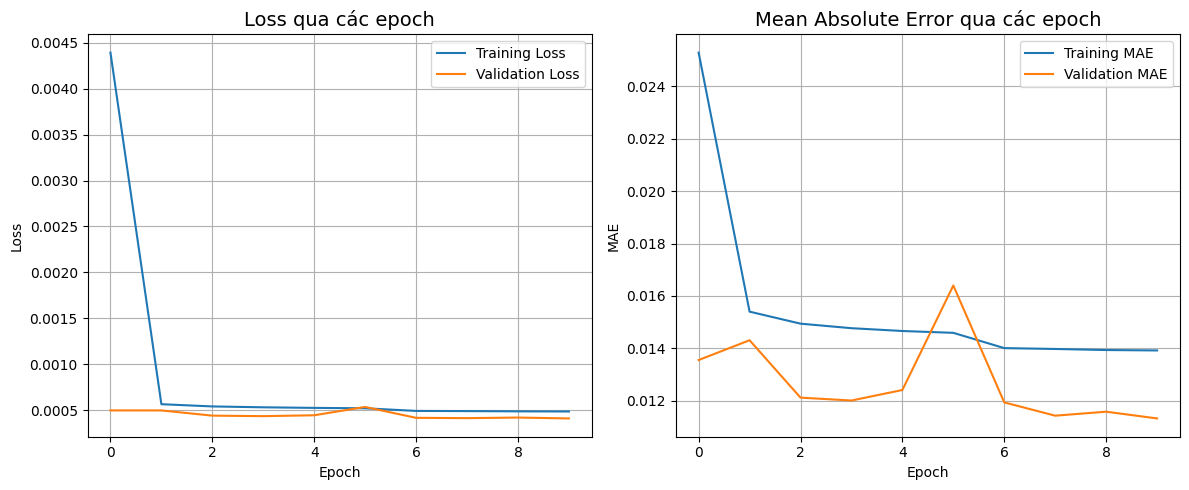

In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN

# --- Ki·ªÉm tra v√† x·ª≠ l√Ω d·ªØ li·ªáu NaN/inf ---
def check_and_clean_data(X_train, X_test, y_train, y_test):
    if np.isnan(X_train).any() or np.isinf(X_train).any() or \
       np.isnan(X_test).any() or np.isinf(X_test).any() or \
       np.isnan(y_train).any() or np.isinf(y_train).any() or \
       np.isnan(y_test).any() or np.isinf(y_test).any():
        print("‚ö†Ô∏è C·∫£nh b√°o: D·ªØ li·ªáu ch·ª©a NaN ho·∫∑c gi√° tr·ªã v√¥ c√πng. ƒêang ti·∫øn h√†nh x·ª≠ l√Ω...")
        X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
        X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
        y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
        y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)
        print("‚úÖ ƒê√£ x·ª≠ l√Ω xong NaN/inf.")
    else:
        print("‚úÖ D·ªØ li·ªáu kh√¥ng ch·ª©a NaN ho·∫∑c gi√° tr·ªã v√¥ c√πng.")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = check_and_clean_data(X_train, X_test, y_train, y_test)

# --- Thi·∫øt l·∫≠p th∆∞ m·ª•c l∆∞u m√¥ h√¨nh ---
os.makedirs('models', exist_ok=True)

# --- Callback ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('models/lstm_best_model3.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4, verbose=1)
terminate_on_nan = TerminateOnNaN()

# --- Hu·∫•n luy·ªán m√¥ h√¨nh ---
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint, reduce_lr, terminate_on_nan],
    verbose=1
)

# --- V·∫Ω bi·ªÉu ƒë·ªì loss & MAE ---
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss qua c√°c epoch', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error qua c√°c epoch', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


## ƒê√°nh gi√° m√¥ h√¨nh v√† l∆∞u m√¥ h√¨nh

In [12]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# S·ª≠ d·ª•ng c√°ch t√≠nh RMSE t∆∞∆°ng th√≠ch v·ªõi m·ªçi phi√™n b·∫£n scikit-learn
try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
except TypeError:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# L∆∞u m√¥ h√¨nh v√† scaler ƒë·ªÉ s·ª≠ d·ª•ng sau
model.save('models/lstm_best_model3.h5')
joblib.dump(scaler, 'models/scaler3.save')

# L∆∞u th√¥ng tin window_size ƒë·ªÉ s·ª≠ d·ª•ng sau n√†y
with open('models/config3.txt', 'w') as f:
    f.write(f"window_size={window_size}")
print("\nƒê√£ l∆∞u m√¥ h√¨nh v√† c·∫•u h√¨nh v√†o th∆∞ m·ª•c 'models/'")

19675/19675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 96s 5ms/step


MAE: 0.0113
RMSE: 0.0200
R2: 0.8760

ƒê√£ l∆∞u m√¥ h√¨nh v√† c·∫•u h√¨nh v√†o th∆∞ m·ª•c 'models/'


## D·ª± b√°o ƒëi·ªán nƒÉng ti√™u th·ª• cho kh√°ch h√†ng theo m√£ kh√°ch h√†ng

Ch·ªâ c·∫ßn nh·∫≠p m√£ kh√°ch h√†ng v√†o bi·∫øn `customer_id` d∆∞·ªõi ƒë√¢y v√† ch·∫°y cell ƒë·ªÉ l·∫•y d·ª± b√°o.

In [5]:
def predict_customer_consumption(customer_code):
    """D·ª± b√°o ƒëi·ªán nƒÉng ti√™u th·ª• cho kh√°ch h√†ng d·ª±a v√†o m√£ kh√°ch h√†ng."""

    # T·∫£i m√¥ h√¨nh v√† scaler
    model = load_model('models/lstm_best_model3.h5', compile=False)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    scaler = joblib.load('models/scaler3.save')

    # C·∫•u h√¨nh window size
    try:
        with open('models/config3.txt', 'r') as f:
            window_size = int(f.read().split('=')[1])
    except:
        window_size = 12

    # L·∫•y d·ªØ li·ªáu kh√°ch h√†ng
    if customer_code not in df_time_ready['MA_KHANG'].values:
        print(f"‚ùå Kh√¥ng t√¨m th·∫•y m√£ KH: {customer_code}")
        return None
    customer_data = df_time_ready[df_time_ready['MA_KHANG'] == customer_code].drop(columns=['MA_KHANG']).iloc[0]
    values = customer_data.values.astype(float)
    values = np.nan_to_num(values, nan=np.nanmean(values))

    # Th·ªëng k√™ c∆° b·∫£n
    mean_val, std_val = np.mean(values[values > 0]), np.std(values[values > 0])
    last_val = next((v for v in reversed(values) if v > 0), mean_val)
    max_val = np.max(values)

    # Chu·∫©n h√≥a v√† d·ª± b√°o
    scaled = scaler.transform(values.reshape(1, -1))
    input_seq = scaled[0, -window_size:].reshape(1, window_size, 1)
    pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
    pred_real = scaler.inverse_transform([[pred_scaled] + [0]*(values.size - 1)])[0, 0]

    # ƒêi·ªÅu ch·ªânh m√πa v·ª•
    month_idx = (np.argmax(values[::-1] > 0) + 1) % 12
    seasonal = 1.15 if 5 <= month_idx <= 9 else 1.0
    pred_real *= seasonal

    # ƒêi·ªÅu ch·ªânh gi·ªõi h·∫°n
    final_pred = np.clip(pred_real, mean_val * 0.8, max(mean_val * 1.5, last_val * 2.0))

    # V·∫Ω bi·ªÉu ƒë·ªì
    months = customer_data.index.astype(str)
    plt.figure(figsize=(15, 7))
    plt.plot(months, values, 'o-', label='L·ªãch s·ª≠')
    plt.plot([months[-1], 'D·ª± b√°o'], [values[-1], final_pred], 'ro--', label='D·ª± b√°o')
    plt.axhline(mean_val, color='green', linestyle='--', label=f'Trung b√¨nh ({mean_val:.1f})')
    plt.text(len(months), final_pred + 5, f'{final_pred:.1f} kWh',
                ha='center', fontsize=12, color='black')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"üî∂ D·ª± b√°o th√°ng t·ªõi: {final_pred:.2f} kWh")
    return final_pred


In [6]:
# Th·ª≠ nghi·ªám v·ªõi kh√°ch h√†ng
predict_customer_consumption('PP07000701228')

NameError: name 'df_time_ready' is not defined